In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
from torchvision.utils import save_image, make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import yaml
import os
import argparse
import numpy as np
from tqdm.autonotebook import tqdm
from PIL import Image
from model.DDPM.ddpmnet import DDPMNet
from runners.utils import mkdir

In [2]:
def show_images(imgs, num_rows, num_cols, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    return axes

In [3]:
mkdir('./jupyter samples/DDPM samples')

def save_sample_img(all_samples, subpath, grid_size=4):
    imgs = []
    sample_path = './jupyter samples/DDPM samples'
    sample_path = os.path.join(sample_path, subpath)
    mkdir(sample_path)
    
    for i, sample in enumerate(tqdm(all_samples, total=len(all_samples), desc='saving images')):
        sample = sample.view(grid_size ** 2, config.data.channels, config.data.image_size,
                                config.data.image_size)

        image_grid = make_grid(sample, nrow=grid_size)
        if i % 10 == 0:
            im = Image.fromarray(
                image_grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
            imgs.append(im)

        if i % 50 == 0:
            save_image(image_grid, os.path.join(sample_path, 'image_{}.png'.format(i)))
            
    image_grid = make_grid(all_samples[-1], nrow=grid_size)
    im = Image.fromarray(
                image_grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
    imgs.append(im)
    save_image(image_grid, os.path.join(sample_path, 'image_{}.png'.format(len(all_samples))))
    imgs[0].save(os.path.join(sample_path, "movie.gif"), save_all=True, append_images=imgs[1:],
                duration=1, loop=0)

## 加载数据集

In [4]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

config = None
with open('./configs/DDPM.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2namespace(config)
config.device = torch.device('cuda:0')
batch_size = config.training.batch_size

In [5]:
trans = transforms.ToTensor()
fashion_mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=trans, download=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

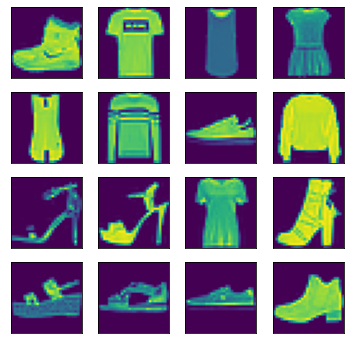

In [6]:
X, y = next(iter(data.DataLoader(fashion_mnist_train, batch_size)))
show_images(X.reshape(batch_size, 28, 28), 4, batch_size // 4)

## 加载模型

In [7]:
ddpmnet = DDPMNet(config).to(config.device)
states = torch.load('./output/DDPM/DDPM/model/checkpoint.pth')
ddpmnet.load_state_dict(states[0])

<All keys matched successfully>

# 1. DDPM前向过程

In [8]:
X = X.to(config.device)
imgs = [X]
for i in tqdm(range(config.model.n_steps), desc='q_sample', total=config.model.n_steps):
    t = torch.full((batch_size,), i).to(config.device)
    img = ddpmnet.q_sample(X, t)
    imgs.append(img)

save_sample_img(imgs, 'forward_process')

q_sample:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/1001 [00:00<?, ?it/s]

<img src="./jupyter samples/DDPM samples/forward_process/movie.gif" width=250 align="left">

# 2. DDPM重建训练集前向的噪声图 

In [9]:
t = torch.full((batch_size,), config.model.n_steps - 1).to(config.device)
perturbed_x = ddpmnet.q_sample(X, t)
all_samples = ddpmnet.p_sample_loop(perturbed_x.shape, perturbed_x)
save_sample_img(all_samples, 'train_perturb_sample')

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/1001 [00:00<?, ?it/s]

<img src="./jupyter samples/DDPM samples/train_perturb_sample/movie.gif" width=250 align="left">

# 3. DDPM重建测试集前向的噪声图

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/1001 [00:00<?, ?it/s]

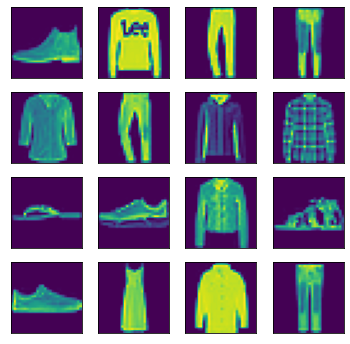

In [10]:
test_X, test_y = next(iter(data.DataLoader(fashion_mnist_test, batch_size=16)))
show_images(test_X.reshape(16, 28, 28), 4, 4)
test_X = test_X.to(config.device)
perturbed_samples = ddpmnet.q_sample(test_X, t)
all_samples = ddpmnet.p_sample_loop(perturbed_samples.shape, perturbed_samples)
save_sample_img(all_samples, 'test_perturb_sample')

<img src="./jupyter samples/DDPM samples/test_perturb_sample/movie.gif" width=250 align="left">

# 4. DDPM从随机噪声采样

In [8]:
noise = torch.randn(X.shape, device=config.device)
all_samples = ddpmnet.p_sample_loop(X.shape, noise)
save_sample_img(all_samples, 'random_sample_1')

sampling loop time step:   0%|          | 0/999 [00:00<?, ?it/s]

saving images:   0%|          | 0/1000 [00:00<?, ?it/s]

<img src="./jupyter samples/DDPM samples/random_sample_1/movie.gif" width=250 align="left">

### 同一个噪声采样两次

In [12]:
all_samples = ddpmnet.p_sample_loop(X.shape, noise)
save_sample_img(all_samples, 'random_sample_2')

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/1001 [00:00<?, ?it/s]

<img src="./jupyter samples/DDPM samples/random_sample_2/movie.gif" width=250 align="left">

# 5. 从不相关的数据集前向噪声采样

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/1001 [00:00<?, ?it/s]

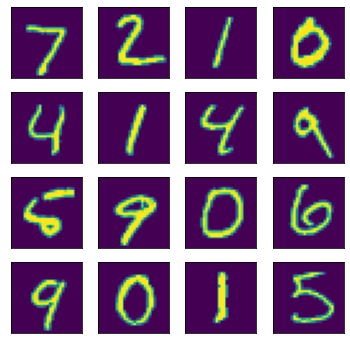

In [13]:
unrelated_X, _= next(iter(data.DataLoader(mnist_test, batch_size=16)))
show_images(unrelated_X.reshape(16, 28, 28), 4, 4)
unrelated_X = unrelated_X.to(config.device)
perturbed_samples = ddpmnet.q_sample(unrelated_X, t)
all_samples = ddpmnet.p_sample_loop(perturbed_samples.shape, perturbed_samples)
save_sample_img(all_samples, 'unrelated_perturb_sample')

<img src="./jupyter samples/DDPM samples/unrelated_perturb_sample/movie.gif" width=250 align="left">

## 6. 中间重建

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

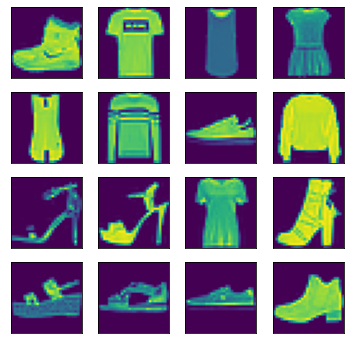

In [8]:
X, y = next(iter(data.DataLoader(fashion_mnist_train, batch_size)))
show_images(X.reshape(batch_size, 28, 28), 4, batch_size // 4)

In [9]:
step = 800
X = X.to(config.device)
t = torch.full((batch_size,), step).to(config.device)
perturbed_x = ddpmnet.q_sample(X, t)
all_samples = ddpmnet.p_sample_loop(perturbed_x.shape, perturbed_x, step)
save_sample_img(all_samples, 'rec_800_sample')

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/801 [00:00<?, ?it/s]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

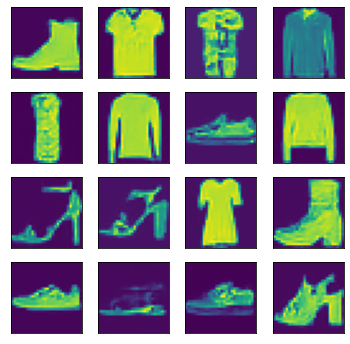

In [12]:
show_images(all_samples[-1].to('cpu').reshape(batch_size, 28, 28), 4, batch_size // 4)

<img src="./jupyter samples/DDPM samples/rec_800_sample/movie.gif" width=250 align="left">

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

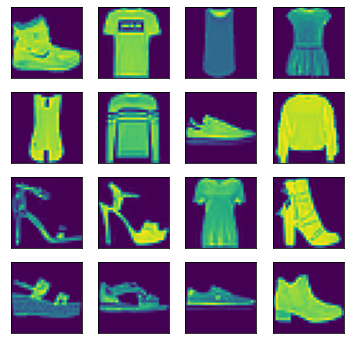

In [15]:
flip_transform = torchvision.transforms.RandomHorizontalFlip(p=1.0)
X_flip = flip_transform(X)
show_images(X_flip.to('cpu').reshape(batch_size, 28, 28), 4, batch_size // 4)

In [17]:
X_flip = X_flip.to(config.device)
t = torch.full((batch_size,), step).to(config.device)
perturbed_x = ddpmnet.q_sample(X_flip, t)
all_samples = ddpmnet.p_sample_loop(perturbed_x.shape, perturbed_x, step)
save_sample_img(all_samples, 'flip_rec_800_sample')

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/801 [00:00<?, ?it/s]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

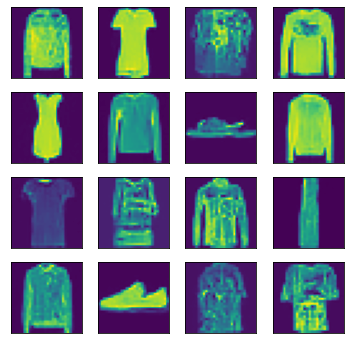

In [18]:
show_images(all_samples[-1].to('cpu').reshape(batch_size, 28, 28), 4, batch_size // 4)

## 测试同一个z进行仿射变换之后

In [46]:
def get_mlp():
    layers = []
    layers.append(nn.Linear(28*28+64, 2048))
    layers.append(nn.Tanh())
    layers.append(nn.Linear(2048, 28*28))
    layers.append(nn.Tanh())
    return nn.Sequential(*layers)
    
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=1)

noise_model = get_mlp().to(config.device)
noise_model.apply(init_weights)
time_emb = nn.Embedding(1000, 64).to(config.device)

In [47]:
@torch.no_grad()
def ddpm_sample(noise):
    noise_model.eval()
    time_emb.eval()
    device = config.device
    imgs = [noise] 
    for i in tqdm(reversed(range(0, ddpmnet.num_timesteps)), desc='sampling loop time step', total=ddpmnet.num_timesteps):
        t = time_emb(torch.full((batch_size,), i, device=device, dtype=torch.long))
        noise = noise_model(torch.cat((noise.reshape(batch_size, -1), t), dim=-1)).reshape(batch_size, 1, 28, 28)
        img = ddpmnet.p_sample(imgs[-1], torch.full((batch_size,), i, device=device, dtype=torch.long), noise=noise)
        imgs.append(img)
    return imgs

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

saving images:   0%|          | 0/1001 [00:00<?, ?it/s]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

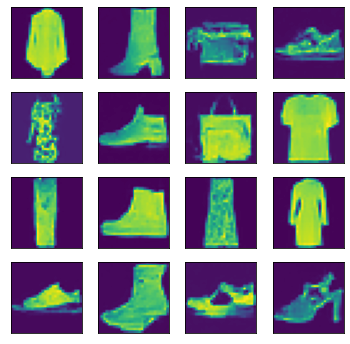

In [48]:
noise = torch.randn(X.shape, device=config.device)
all_samples = ddpm_sample(noise)
save_sample_img(all_samples, 'noise_affine_sample')
show_images(all_samples[-1].to('cpu').reshape(batch_size, 28, 28), 4, batch_size // 4)

<img src="./jupyter samples/DDPM samples/noise_affine_sample/movie.gif" width=250 align="left">